In [2]:
# Install necessary packages
!pip install torch torchvision transformers accelerate scikit-learn tqdm

In [8]:
# Import necessary libraries
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from transformers import AutoImageProcessor, AutoModel
from tqdm import tqdm
import torch.nn as nn
import json
import time
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR-10 dataset
train_ds = CIFAR10(root="./data", train=True, download=True)
test_ds  = CIFAR10(root="./data", train=False, download=True)

# Limit the data to smaller subsets for quick testing (optional)
train_ds.data = train_ds.data[:5000]  # Adjust size if you're using a CPU
test_ds.data  = test_ds.data[:1000]   # Test set also smaller for quick tests


In [4]:
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")

# Preprocessing function
def collate_pil(batch):
    images, labels = list(zip(*batch))
    inputs = processor(images=list(images), return_tensors="pt")
    labels = torch.tensor(labels, dtype=torch.long)
    return inputs["pixel_values"], labels

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, collate_fn=collate_pil)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=2, collate_fn=collate_pil)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [9]:
# Load DINOv2 pre-trained backbone (Facebook DINOv2-small)
backbone = AutoModel.from_pretrained("facebook/dinov2-small").to(device)

# Freeze the backbone
for p_ in backbone.parameters():
    p_.requires_grad = False
backbone.eval()

# Extract hidden size (DINOv2-small's output size)
hidden_size = backbone.config.hidden_size

In [10]:
# Linear classifier head

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

head = nn.Linear(hidden_size, 10).to(device)  # 10 classes for CIFAR-10

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(head.parameters(), lr=1e-3)

Using device: cuda


In [11]:
@torch.no_grad()
def extract_cls(pixel_values):
    # Extract CLS token from DINOv2 model
    out = backbone(pixel_values=pixel_values)
    cls = out.last_hidden_state[:, 0, :]  # CLS token embedding
    return cls

def run_epoch(loader, train: bool):
    if train:
        head.train()
    else:
        head.eval()
    total, correct, running_loss = 0, 0, 0.0
    for pix, y in tqdm(loader, leave=False):
        pix, y = pix.to(device), y.to(device)
        feats = extract_cls(pix)  # Get DINOv2 embeddings
        logits = head(feats)  # Classify with the head
        loss = criterion(logits, y)

        if train:
            optim.zero_grad()
            loss.backward()
            optim.step()

        running_loss += loss.item() * y.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total   += y.size(0)
    return running_loss/total, correct/total

# Training loop
metrics = {"train": [], "test": []} # Initialize metrics dictionary
for epoch in range(1, 6):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    test_loss, test_acc = run_epoch(test_loader, train=False)
    print(f"Epoch {epoch}: Train Loss={train_loss:.4f} Train Acc={train_acc:.4f} Test Loss={test_loss:.4f} Test Acc={test_acc:.4f}")

    # Append metrics after each epoch
    metrics["train"].append({"loss": train_loss, "acc": train_acc})
    metrics["test"].append({"loss": test_loss, "acc": test_acc})

Epoch 1: Train Loss=0.6163 Train Acc=0.8094 Test Loss=0.1742 Test Acc=0.9540


Epoch 2: Train Loss=0.1461 Train Acc=0.9530 Test Loss=0.1339 Test Acc=0.9610


Epoch 3: Train Loss=0.1021 Train Acc=0.9692 Test Loss=0.1219 Test Acc=0.9620


Epoch 4: Train Loss=0.0786 Train Acc=0.9794 Test Loss=0.1157 Test Acc=0.9630


Epoch 5: Train Loss=0.0631 Train Acc=0.9836 Test Loss=0.1163 Test Acc=0.9620


In [12]:
# Save model weights
torch.save({
    "head_state_dict": head.state_dict(),
    "hidden_size": hidden_size,
    "model_id": "facebook/dinov2-small"
}, "linear_head.pth")

# Save metrics
with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

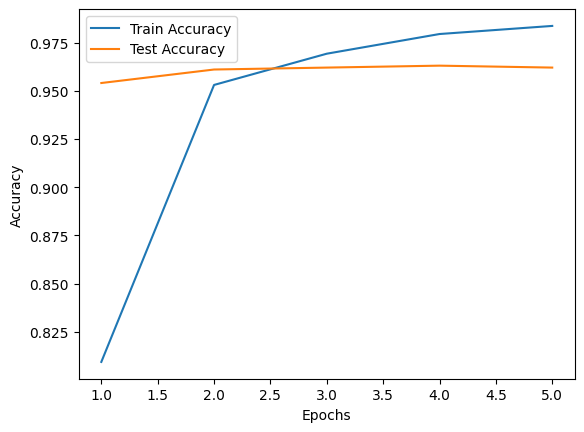

In [13]:
import matplotlib.pyplot as plt

with open("metrics.json", "r") as f:
    metrics = json.load(f)

train_acc = [epoch["acc"] for epoch in metrics["train"]]
test_acc = [epoch["acc"] for epoch in metrics["test"]]

plt.plot(range(1, 6), train_acc, label="Train Accuracy")
plt.plot(range(1, 6), test_acc, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


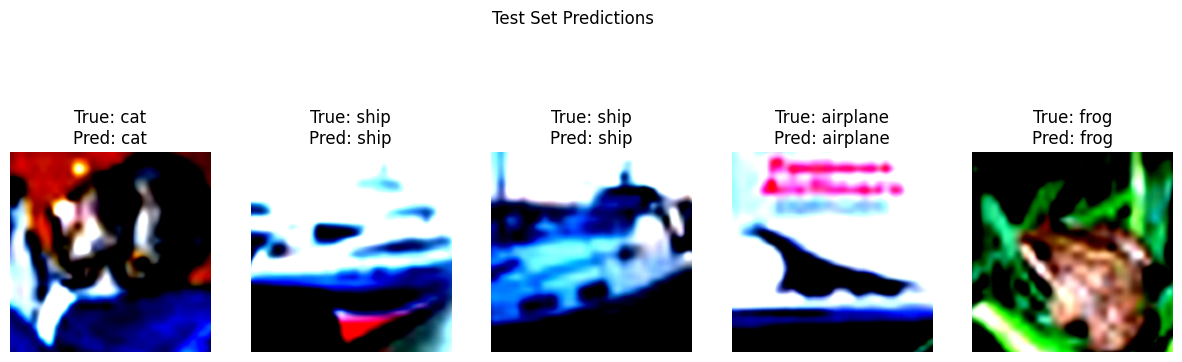

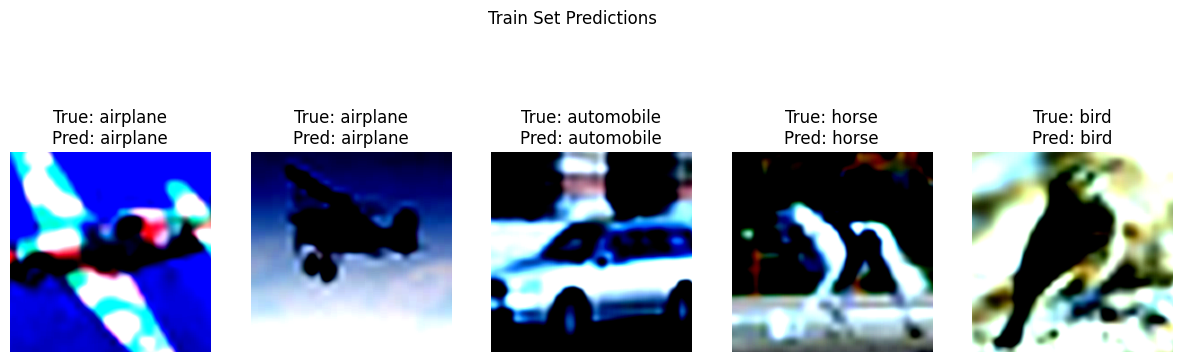

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid

# Function to plot images with their actual and predicted labels
def plot_images(images, labels, preds, class_names, title="Images"):
    # Ensure images are in a displayable format (e.g., numpy array with shape HxWx channels)
    # Depending on the output of the dataloader and processor, this might need adjustment.
    # Assuming images are already processed and are torch tensors.
    # If images are normalized, they might need to be unnormalized before plotting.
    # For now, assuming images are in a format suitable for imshow.
    images = images.cpu().numpy().transpose((0, 2, 3, 1))  # Convert from torch tensor (BxCxHxW) to numpy (BxHxWx channels)
    # If images were normalized, unnormalize them here:
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # images = std * images + mean
    # images = np.clip(images, 0, 1)


    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    if len(images) == 1: # Handle single image case
        axes = [axes]
    for i, ax in enumerate(axes):
        ax.imshow(images[i])  # Display the image
        true_label = class_names[labels[i]]
        predicted_label = class_names[preds[i]]
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}")
        ax.axis('off')  # Turn off axis
    plt.suptitle(title)
    plt.show()

# Get a few sample images from the test set
def visualize_predictions(model, dataloader, device, class_names, num_images=5):
    model.eval()  # Set model to evaluation mode
    images, labels = next(iter(dataloader))  # Get a batch of images and labels

    # Select only num_images from the batch
    images = images[:num_images].to(device)
    labels = labels[:num_images].to(device)


    # Get the model predictions
    with torch.no_grad():
        # Extract DINOv2 features
        features = extract_cls(images)
        # Classify with the head
        outputs = model(features)
        _, preds = torch.max(outputs, 1)

    # Plot the images, actual labels, and predictions
    plot_images(images.cpu(), labels.cpu(), preds.cpu(), class_names, title="Test Set Predictions")

# Get a few sample images from the training set
def visualize_train_predictions(model, dataloader, device, class_names, num_images=5):
    model.eval()  # Set model to evaluation mode
    images, labels = next(iter(dataloader))  # Get a batch of images and labels

    # Select only num_images from the batch
    images = images[:num_images].to(device)
    labels = labels[:num_images].to(device)

    # Get the model predictions
    with torch.no_grad():
        # Extract DINOv2 features
        features = extract_cls(images)
        # Classify with the head
        outputs = model(features)
        _, preds = torch.max(outputs, 1)

    # Plot the images, actual labels, and predictions
    plot_images(images.cpu(), labels.cpu(), preds.cpu(), class_names, title="Train Set Predictions")

# Get the class names (CIFAR-10 labels)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize predictions on the test set
visualize_predictions(head, test_loader, device, class_names, num_images=5)

# Visualize predictions on the train set
visualize_train_predictions(head, train_loader, device, class_names, num_images=5)